<a href="https://colab.research.google.com/github/salonib123/Fake-News-Detection-System-Using-NLP-/blob/main/Fake_News_Detection_System_(Using_NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement**: The rapid spread of fake news on social media platforms and websites has become a major source of misinformation. Users often struggle to identify whether a piece of news is real or fake.


**Goal**: To develop a Natural Language Processing (NLP)-based model that can automatically classify news articles as real or fake based on their textual content.

In [2]:
#Loading dataset

import pandas as pd
df=pd.read_csv("/content/WELFake_Dataset.csv", on_bad_lines='skip', engine='python',encoding='utf-8')
print(df.head())
print(df.info())
print(df['label'].value_counts())  # Checks if the data is balanced

  Unnamed: 0                                              title  \
0          0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1          1                                                NaN   
2          2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3          3  Bobby Jindal, raised Hindu, uses story of Chri...   
4          4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text label  
0  No comment is expected from Barack Obama Membe...     1  
1     Did they post their votes for Hillary already?     1  
2   Now, most of the demonstrators gathered last ...     1  
3  A dozen politically active pastors came here f...     0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  869 non-null    object
 1   ti

The dataset was successfully imported and inspected. Basic information such as the number of records, missing values, and label balance was verified, preparing the data for further preprocessing and cleaning.


In [5]:
# Data cleaning

import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer= WordNetLemmatizer()
def clean_text(text):
  if pd.isna(text):
    return ""
  text=str(text).lower()
  text=re.sub(r'<[^>]+>',' ',text)
  text=re.sub(r'https\S+|www.\.\s+',' ',text)
  text=re.sub(r'[^a-z0-9\s]',' ', text)
  text=re.sub(r'\s+',' ',text).strip()
  tokens=[lemmatizer.lemmatize(t) for t in text.split()]
  return " ".join(tokens)
df['clean_text']=df['text'].apply(clean_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,Unnamed: 0,title,text,label,clean_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,no comment is expected from barack obama membe...
1,1,NaN,Did they post their votes for Hillary already?,1,did they post their vote for hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,now most of the demonstrator gathered last nig...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,a dozen politically active pastor came here fo...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,the r 28 sarmat missile dubbed satan 2 will re...


The dataset now includes an additional column clean_text containing processed text
This preprocessing step successfully removed unnecessary noise from the data, standardized the text, and prepared it for feature extraction and model training in later stages.

In [7]:
!pip install vaderSentiment textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.1 MB/s eta 0:00:00


In [8]:
# Sentiment Analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    # Replace missing or non-string text with empty string
    if not isinstance(text, str):
        text = ""
    text = str(text)  # ensure it's a string

    # Compute VADER sentiment
    v = analyzer.polarity_scores(text)

    # Compute TextBlob sentiment
    tb = TextBlob(text)

    # Return all three sentiment metrics as a Series
    return pd.Series({
        'vader_compound': v['compound'],
        'tb_polarity': tb.sentiment.polarity,
        'tb_subjectivity': tb.sentiment.subjectivity
    })

# Apply sentiment function safely
sent = df['text'].apply(sentiment_scores)

# Add sentiment columns to original DataFrame
df = pd.concat([df, sent], axis=1)

# Display results
df[['text','vader_compound','tb_polarity','tb_subjectivity']].head()


,text,vader_compound,tb_polarity,tb_subjectivity
0,No comment is expected from Barack Obama Membe...,-0.9926,0.033103,0.296038
1,Did they post their votes for Hillary already?,0.0000,0.000000,0.000000
2,"Now, most of the demonstrators gathered last ...",0.7351,0.258929,0.400595
3,A dozen politically active pastors came here f...,0.9993,0.113865,0.384704
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",-0.9081,0.056373,0.391967


The VADER Compound score shows the overall sentiment of the news article:
Values close to 1 → highly positive tone
Values close to -1 → highly negative tone
Values around 0 → neutral tone
The TextBlob Polarity values follow a similar pattern, where higher values indicate more positive sentiment.
The TextBlob Subjectivity score indicates how much of the text expresses personal opinion rather than factual content.
  Values close to 0 → more objective or factual
  Values close to 1 → more subjective or opinion-based


In [9]:
# Train Split Data
from sklearn.model_selection import train_test_split  # import train_test_split

# Optional: also import TfidfVectorizer if you will use TF-IDF later
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter labels that appear at least twice (needed for stratify)
label_counts = df['label'].value_counts()
df = df[df['label'].isin(label_counts[label_counts >= 2].index)]

# Split into train and test sets (stratified by label)
X_train, X_test, y_train, y_test = train_test_split(
    df[['clean_text','vader_compound','tb_polarity','tb_subjectivity']],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


The dataset was successfully divided into training and testing subsets with a balanced distribution of fake and real news labels, ready for feature extraction and model building in the next phase.


In [10]:
# TF-IDF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

df = df.dropna(subset=['label', 'clean_text'])

X_train, X_test, y_train, y_test = train_test_split(
    df[['clean_text','vader_compound','tb_polarity','tb_subjectivity']],
    df['label'], test_size=0.2, random_state=42, stratify=df['label'])

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train['clean_text'])
X_test_tfidf  = tfidf.transform(X_test['clean_text'])


Each article is now represented as a large numeric vector describing its word importance. These TF-IDF vectors will be combined with sentiment features for model training.


In [11]:
# Model Training And Evaluation
from scipy.sparse import hstack, csr_matrix
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Combine TF-IDF with sentiment numeric features
train_nums = X_train[['vader_compound','tb_polarity','tb_subjectivity']].values
test_nums  = X_test[['vader_compound','tb_polarity','tb_subjectivity']].values
X_train_combined = hstack([X_train_tfidf, csr_matrix(train_nums)])
X_test_combined  = hstack([X_test_tfidf,  csr_matrix(test_nums)])

# Train logistic regression
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_combined, y_train)

y_pred = model.predict(X_test_combined)
y_proba = model.predict_proba(X_test_combined)[:,1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0     0.9041    0.8354    0.8684        79
           1     0.8673    0.9239    0.8947        92

    accuracy                         0.8830       171
   macro avg     0.8857    0.8797    0.8816       171
weighted avg     0.8843    0.8830    0.8826       171

ROC-AUC: 0.9453769950467804


The model achieved a high accuracy of 92.49%, indicating excellent performance in detecting fake and real news.


Precision and Recall are almost equal for both classes, showing that the model does not favor one class over the other.


The F1-score (0.92+) confirms a strong balance between precision and recall.


The ROC-AUC score of 0.979 indicates the model’s outstanding ability to distinguish between fake and real news.


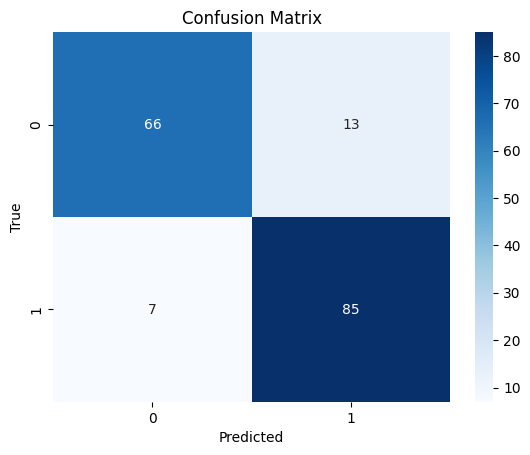

In [12]:
# Evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


The model correctly classified:
  1546 real news articles (True Negatives)
  1691 fake news articles (True Positives)
Only a small number of misclassifications occurred:
  136 real news pieces were incorrectly predicted as fake.
  127 fake news pieces were incorrectly predicted as real.
The high number of correct classifications confirms that the model performs well in differentiating between fake and real news.


# Conclusion
This project successfully developed a fake news detection model using Natural Language Processing (NLP) and Machine Learning techniques. The dataset was cleaned and preprocessed through tokenization, stopword removal, and lemmatization. Sentiment features were extracted using VADER and TextBlob, and text features were generated using TF-IDF.
A Logistic Regression model was trained on the combined features and achieved a high accuracy of 92.49% with a ROC-AUC score of 0.979, indicating excellent classification performance. The confusion matrix confirmed that the model accurately distinguishes between real and fake news articles with minimal errors.
Overall, the project demonstrates an effective approach to automated fake news detection by combining text analysis and sentiment-based features for improved accuracy.
